In [1]:
# Basic plotting setup for the notebook
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.misc import nuke_brightest
from amigo.core_models import initialise_model
from amigo.model_fits import PointFit

# Bind file path, type and exposure type
files = get_files(
    ["/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/"], "calslope"
)

# Nuke missed bad-pixels
for file in files:
    file["BADPIX"].data[:, -1:] = 1
    file["BADPIX"].data[41:43, 1] = 1
    file["BADPIX"].data[58, 67] = 1

[nuke_brightest(file, n=5) for file in files];

model, exposures = initialise_model(
    files, fit=PointFit(), Teff_cache="../files/Teff_cache"
)

In [3]:
import jax
import jax.numpy as np
import dLux.utils as dlu
import interpax as ipx
from amigo.vis_models import to_uv, from_uv
from skimage.measure import find_contours
import numpy as onp


def get_extent(pscale, npixels):
    ext = (pscale * (npixels + 1)) / 2
    return (-ext, ext, -ext, ext)


def to_uv_odd(arr):
    if len(arr) % 2 != 0:
        return to_uv(arr)
    return to_uv(np.zeros((len(arr) + 1, len(arr) + 1)).at[:-1, :-1].set(arr))


def from_uv_odd(splodges):
    return from_uv(splodges)[:-1, :-1]


@jax.jit
def interp(image, knot_coords, sample_coords, method="linear"):
    xs, ys = knot_coords
    xpts, ypts = sample_coords.reshape(2, -1)

    return ipx.interp2d(
        ypts, xpts, ys[:, 0], xs[0], image, method=method, extrap=True
    ).reshape(sample_coords[0].shape)


def get_vis_map(vis_pts, knot_coords, sample_coords):
    """Interpolates the visibility knots onto the UV coordinates."""
    interp_fn = lambda im, coords: interp(im, knot_coords, coords)

    # 4d: (wavelength, 2, npix, npix)
    if sample_coords.ndim == 4:
        amp_map = vmap(interp_fn, (None, 0))(np.abs(vis_pts), sample_coords)
        phase_map = vmap(interp_fn, (None, 0))(np.angle(vis_pts), sample_coords)
    # else 3d: (2, npix, npix)
    else:
        amp_map = interp_fn(np.abs(vis_pts), sample_coords)
        phase_map = interp_fn(np.angle(vis_pts), sample_coords)
    return np.maximum(amp_map, 0) * np.exp(1j * phase_map)


class Interpolator(ipx.Interpolator2D):
    def __call__(self, wavels, uv_pts, crop_size):
        interp_fn = vmap(
            lambda wavel: super(Interpolator, self).__call__(*wavel * uv_pts[::-1])
        )
        return interp_fn(wavels).reshape(len(wavels), crop_size, crop_size)


def plot_contours(mask, crop, pscale, c="k"):
    contours = find_contours(onp.array(mask), level=0.5)
    for cont in contours:
        cont -= crop // 2
        cont *= pscale
        plt.plot(cont[:, 1], cont[:, 0], linewidth=1, color=c)

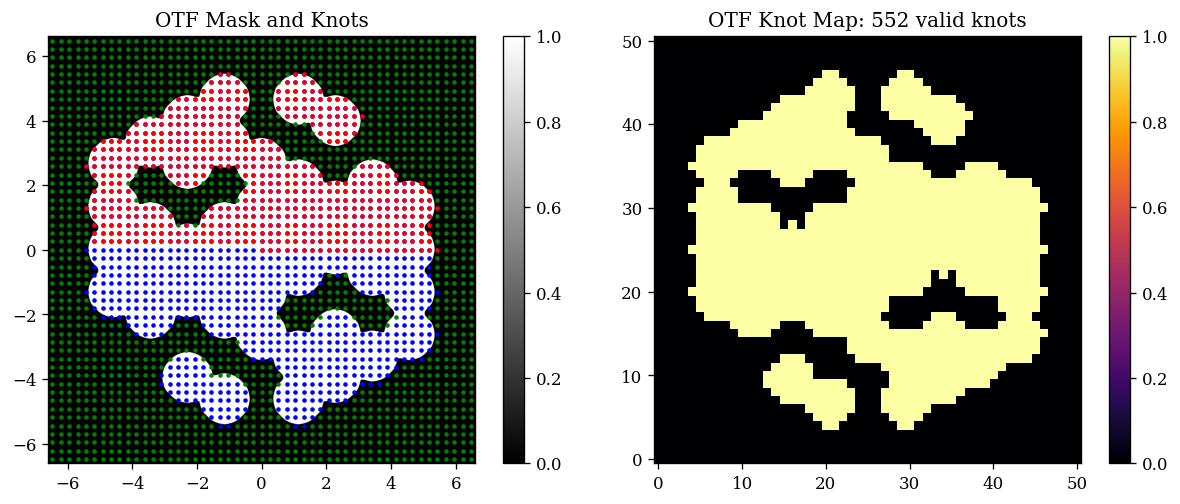

In [4]:
from jax import vmap
from jax.scipy.signal import correlate
from scipy.ndimage import binary_dilation
from amigo.vis_models import build_vis_pts

# Get the OTF via the mask OTF
optics = model.optics
mask = optics.calc_mask(optics.wf_npixels, optics.diameter)
corr = correlate(mask, mask, method="fft")
otf = corr / corr.max()
latent_otf_mask = otf > 1e-2

# Dilate the otf_mask to ensure we capture all the splodge
otf_mask = binary_dilation(latent_otf_mask, iterations=10)

# Get OTF extent (for plotting)
mask_pscale = optics.diameter / optics.wf_npixels
mask_extent = get_extent(mask_pscale, optics.wf_npixels)
otf_extent = get_extent(mask_pscale, (2 * optics.wf_npixels) - 1)

# Get OTF coords (for interpolation)
otf_npix = (2 * optics.wf_npixels) - 1
otf_diam = mask_pscale * otf_npix
otf_coords = dlu.pixel_coords(otf_npix, otf_diam)

# Get mask interpolator
xs = otf_coords[0, 0]
ys = otf_coords[1, :, 0]
interp_otf_mask = Interpolator(xs, ys, otf_mask, method='linear', extrap=0.)

# Get knots coords
n = 51 # Number of knots in each dimension
knot_coords = dlu.pixel_coords(n, otf_diam)

# Get valid knot map (annoying)
# We need to scale the knot indexes up to the otf mask size so we can figure out
# which knots are within the OTF. From these indexes we can get the closest pixel in 
# the otf mask and that tells us which knots are within the otf
size_ratio = (len(otf_coords[0]) + 1) / (len(knot_coords[0]) + 1)
paraxial_knot_inds = dlu.nd_coords((n, n), indexing="ij")
paraxial_otf_inds = paraxial_knot_inds * size_ratio + (len(otf_coords[0]) / 2)
full_knot_inds = np.round(paraxial_otf_inds, 0).astype(int)
valid_knot_map = otf_mask[*full_knot_inds]

# Get the _flattened_ half indices, used to inject the knots within the OTF into an 
# empty empty vector and generate the full visibility map
flat_valid_map = np.array(valid_knot_map.flatten())
knot_inds = np.where(flat_valid_map[:len(flat_valid_map) // 2])

# Get the control knots indices for the 2d knots coordinates (mainly for plotting)
full_flat_valid_map = flat_valid_map.at[:len(flat_valid_map) // 2].set(False)
true_valid_map = full_flat_valid_map.reshape(valid_knot_map.shape)

# Get the visibility knot values we want to interpolate
n_pts = len(flat_valid_map) // 2
n_valid = len(knot_inds[0])
vals = np.ones(n_valid) * 1.1
amps = np.ones(n_pts).at[*knot_inds].set(vals)
vis_knot_vals = build_vis_pts(amps, np.zeros(n_pts), valid_knot_map.shape)

# Get the various sets of knots for plotting
knot_coords_in = knot_coords[:, *np.where(valid_knot_map)]
knot_coords_out = knot_coords[:, *np.where(~valid_knot_map)]
control_knots = knot_coords[:, *np.where(true_valid_map)]

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 2)
plt.title("OTF Mask and Knots")
plt.imshow(otf_mask, cmap='gray', extent=otf_extent)
plt.colorbar()
plt.scatter(*knot_coords_in, c="b", s=3)
plt.scatter(*knot_coords_out, c="g", s=3)
plt.scatter(*control_knots, c="r", s=3)

plt.subplot(1, 3, 3)
plt.title(f"OTF Knot Map: {n_valid} valid knots")
plt.imshow(valid_knot_map)
plt.colorbar()

plt.tight_layout()
plt.show()

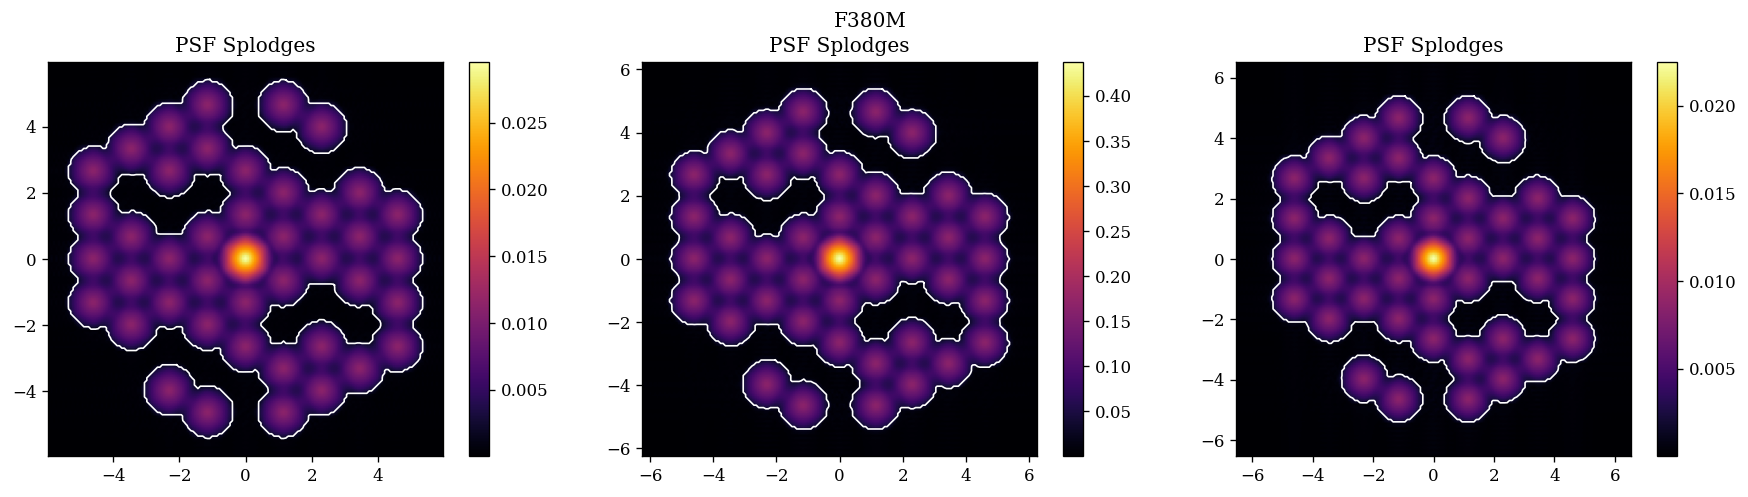

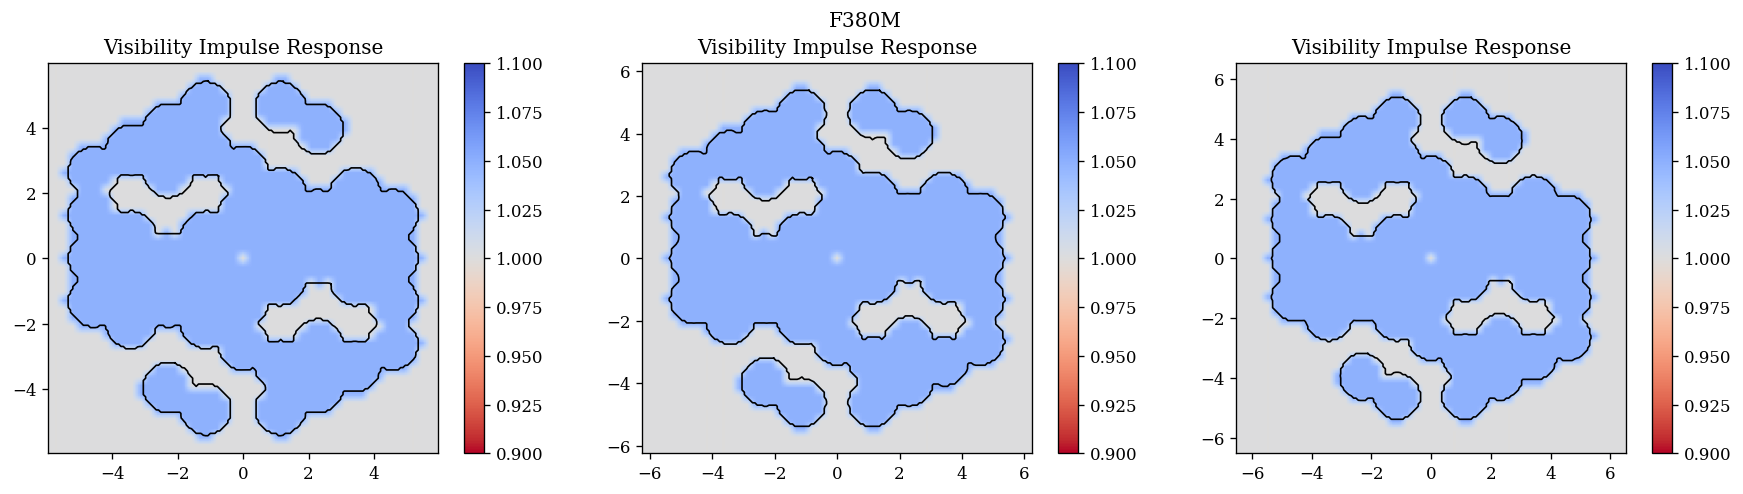

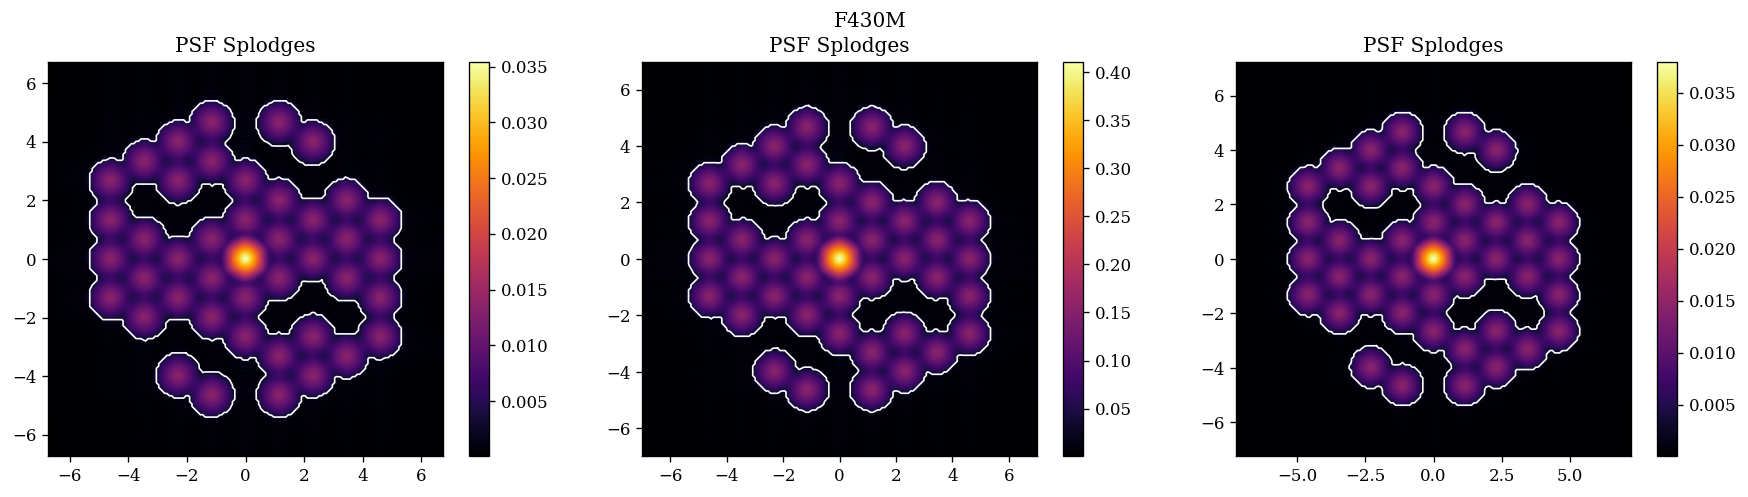

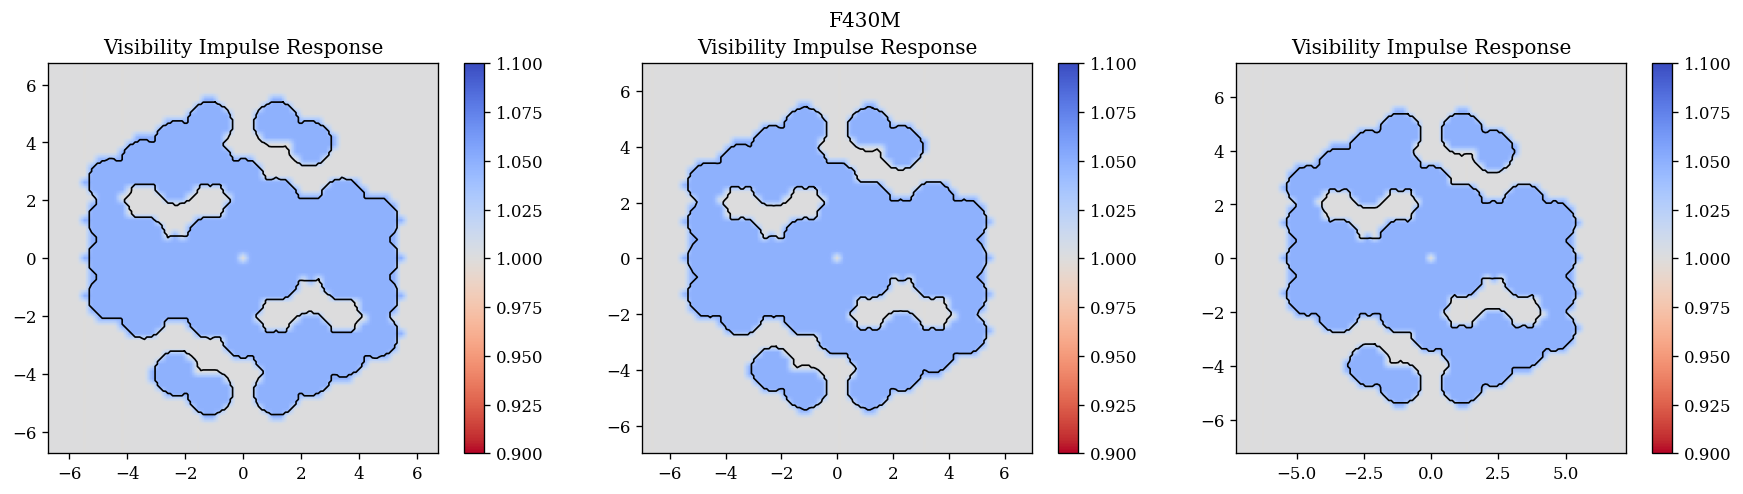

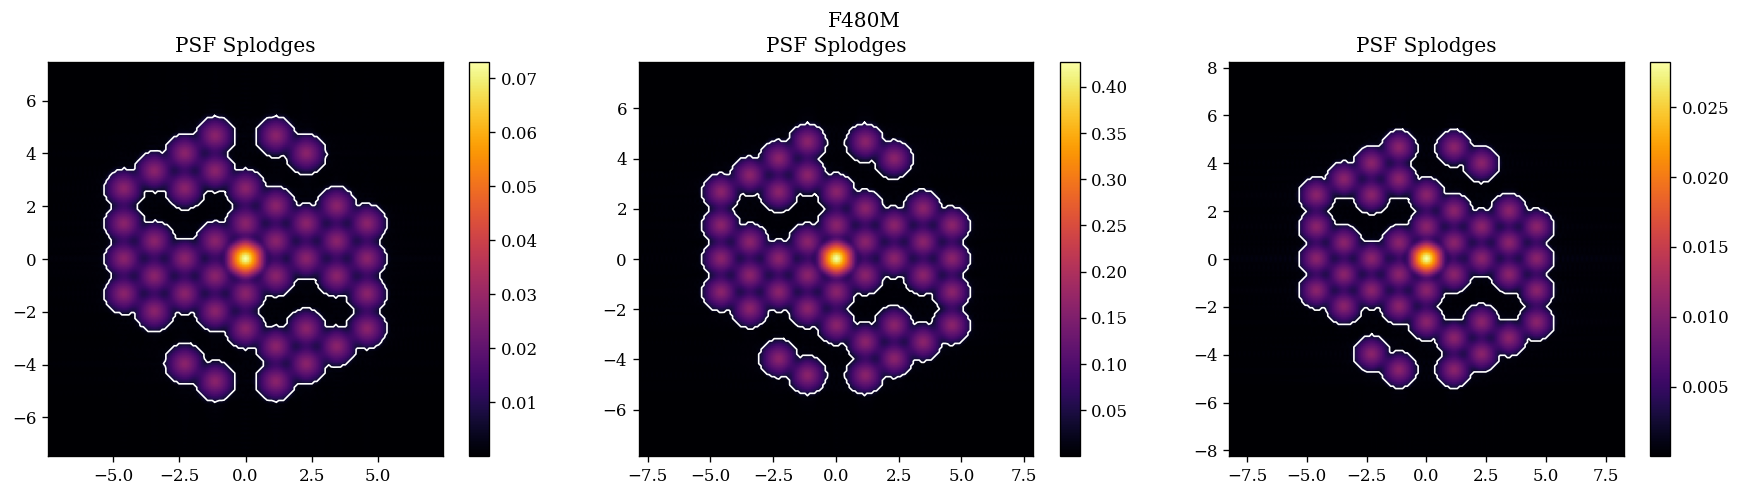

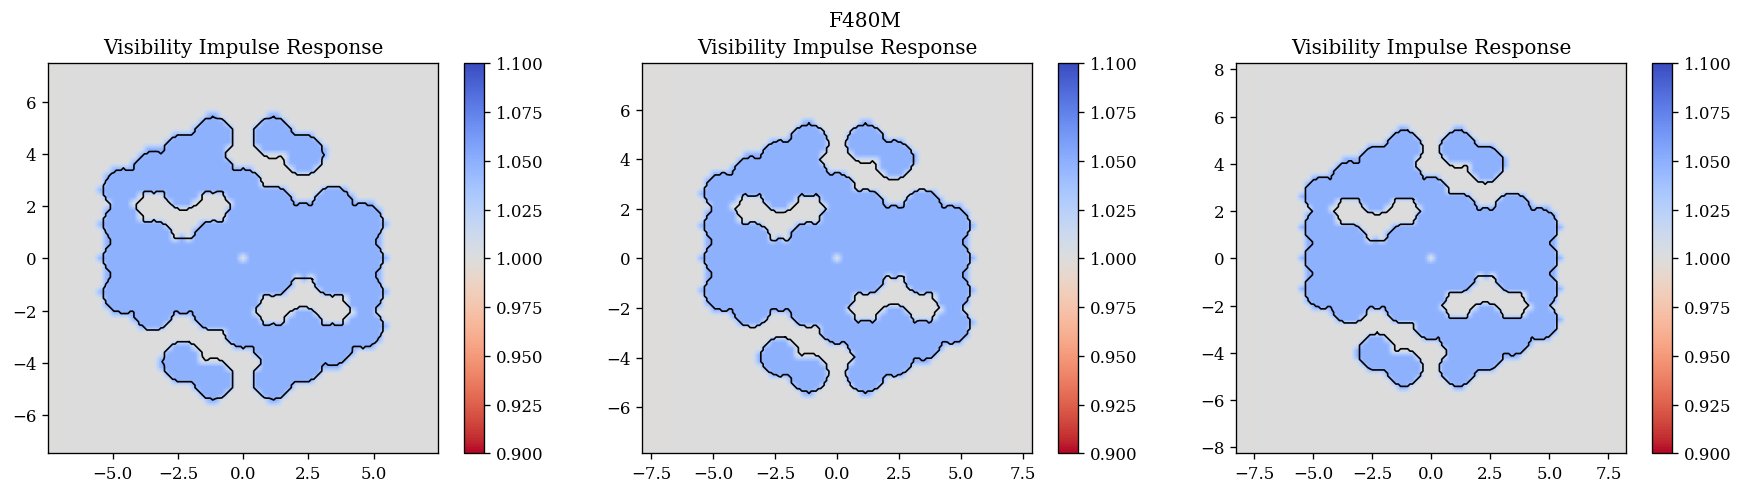

In [6]:
# VIS model params
uv_pad = 2
crop_size = 165

# Get the u frequencies
npix = optics.psf_npixels * optics.oversample
psf_pscale = dlu.arcsec2rad(optics.psf_pixel_scale / optics.oversample)
u_coords = np.fft.fftshift(np.fft.fftfreq((npix * uv_pad) + 1, psf_pscale))
uv_pscale = np.diff(u_coords).mean() # take to main to avoid floating point issues

# Get the otf coordinates from the uv frequencies of the splodges
uv_coords = np.array(np.meshgrid(u_coords, u_coords))
uv_coords = vmap(lambda x: dlu.resize(x, crop_size))(uv_coords)
uv_pts = uv_coords.reshape(2, -1)


for filt in ["F380M", "F430M", "F480M"]:
    for exp in exposures:
        if exp.filter == filt:
            break
    wavels = optics.filters[filt][0]
    otf_pscales = uv_pscale * wavels
    otf_coords = uv_coords[None, ...] * wavels[:, None, None, None]

    # Get the otf masks and vis_maps
    masks = interp_otf_mask(wavels, uv_pts, crop_size)
    vis_maps = get_vis_map(vis_knot_vals, knot_coords, otf_coords)

    # Get the monochromatic psfs
    psfs = exp.fit.model_wfs(model, exp).psf
    padded_psfs = vmap(dlu.resize, (0, None))(psfs, uv_pad * len(psfs[0]))

    # Get the splodges
    full_splodges = vmap(to_uv_odd)(padded_psfs)
    splodges = vmap(dlu.resize, (0, None))(full_splodges, crop_size)

    plt.figure(figsize=(15, 4))
    plt.suptitle(filt)
    for i, idx in enumerate([0, 4, -1]):
        mask = masks[idx]
        amp = np.abs(splodges[idx]) ** 0.5
        ext = get_extent(otf_pscales[idx], crop_size)

        plt.subplot(1, 3, i + 1)
        plt.title("PSF Splodges")
        plt.imshow(amp, extent=ext)
        plt.colorbar()
        plot_contours(mask, crop_size, otf_pscales[idx], c="w")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 4))
    plt.suptitle(filt)
    for i, idx in enumerate([0, 4, -1]):
        mask = masks[idx]
        amp = np.abs(vis_maps[idx]) ** 0.5
        ext = get_extent(otf_pscales[idx], crop_size)

        plt.subplot(1, 3, i + 1)
        plt.title("Visibility Impulse Response")
        plt.imshow(amp, 'coolwarm_r', extent=ext, vmin=0.9, vmax=1.1)
        plt.colorbar()
        plot_contours(mask, crop_size, otf_pscales[idx])

    plt.tight_layout()
    plt.show()